# Analisando a rotatividade do cliente

'Customer Churn' é a perda de clientes ou clientes. Para evitar a perda de clientes, a empresa precisa examinar por que seus clientes o abandonaram no passado.

### Como podemos usar a ciência de dados para entender melhor a rotatividade de clientes?

## A Ferramenta: Análise de Sobrevivência

Para fazer isso, vamos usar uma ferramenta de um lugar improvável (medicina), a análise de sobrevivência.
A análise de sobrevivência foi desenvolvida primeiro por estatísticos e profissionais médicos para prever as taxas de sobrevivência de paciente.

A análise de sobrevivência funciona muito bem em situações como:

- O 'Nascimento': para a nossa aplicação, será um cliente celebrando um contrato com uma empresa
- E a 'Morte': para nós, 'morte' é um cliente encerrando um relacionamento com uma empresa

O componente que torna a análise de sobrevivência superior a outros modelos de regressão é sua capacidade de lidar com a censura nos dados.

No sentido tradicional, a censura pode referir-se à perda de controle de um indivíduo ou de um indivíduo não morrer antes do final de um período de observação. Esses dados são 'censurados' porque todo mundo morre eventualmente, estamos apenas perdendo os dados.

Da mesma forma, esperaríamos perder todos os clientes eventualmente. Só porque não os observamos cancelando o contato, não significa que nunca o farão.

## O Problema: Churn do Cliente em Telecom

Treselle Systems, um serviço de consultoria de dados americana, analisou dados de rotatividade de clientes usando regressão logística. (http://www.treselle.com/blog/customer-churn-logistic-regression-with-r/).

Essa abordagem funciona para uma classificação binária de se um cliente saiu ou não, mas a análise de sobrevivência é muito mais apropriada.

Os dados analisados podem ser encontrados [aqui] (https://github.com/treselle-systems/customer_churn_analysis).

Nosso objetivo é refazer o estudo e identificar maneiras para a empresa de telecomunicações reduzir a rotatividade de clientes.

## A Análise: Biblioteca Lifelines em Python

Para nossa análise, usaremos a biblioteca de linhas de vida em Python. Nosso primeiro passo será instalar e importar a biblioteca, junto com alguns dos clássicos.

In [1]:
#!pip install lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines

A seguir, importaremos os dados e realizaremos algumas limpezas básicas.

Para cada cliente, precisaremos de dois pontos de dados importantes:

- 'Posse': há quanto tempo ele é cliente quando os dados são observados
- 'Churn': se o cliente saiu ou não quando os dados foram observados

Primeiro identificaremos esses recursos e garantiremos que o tipo de dados está correto. Nota, muitos clientes em nossos dados ainda não saíram.

In [2]:
churn_data = pd.read_csv(
    'https://raw.githubusercontent.com/treselle-systems/'
    'customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
# transforma os recursos de posse e rotatividade
churn_data['tenure'] = churn_data['tenure'].astype(float)
churn_data['Churn'] = churn_data['Churn'] == 'Yes'
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,False
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,True


Antes de prosseguirmos em qualquer análise, vamos examinar a taxa de sobrevivência do cliente médio usando uma curva de sobrevivência de Kaplan-Meier.

Usando o código abaixo, podemos ajustar uma curva de sobrevivência KM aos dados de rotatividade do cliente e traçar nossa curva de sobrevivência com um intervalo de confiança.

A curva de sobrevivência é cumulativa. Ou seja, no gráfico abaixo, após 20 meses, a chance de um cliente não cancelar o serviço é pouco acima de 80%.

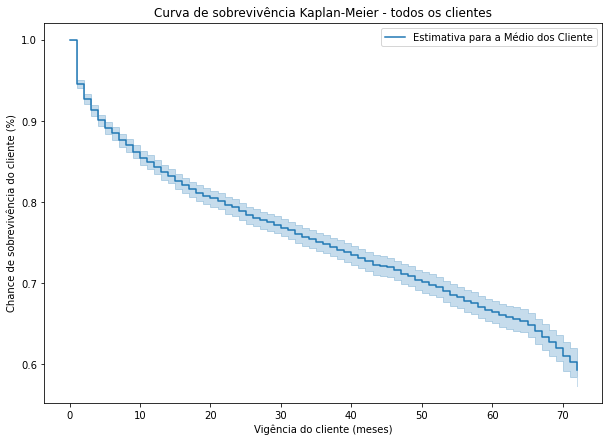

In [3]:
# Treinando kmf para dados de churn
t = churn_data['tenure'].values
churn = churn_data['Churn'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(t, event_observed=churn, label='Estimativa para a Médio dos Cliente')

# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
ax.set_title('Curva de sobrevivência Kaplan-Meier - todos os clientes')
ax.set_xlabel('Vigência do cliente (meses)')
ax.set_ylabel('Chance de sobrevivência do cliente (%)')
plt.show()

O que foi dito antes, devemos tentar entender algumas características básicas sobre os clientes.

Como seria de se esperar para telecomunicações, o churn é relativamente baixo. Mesmo depois de 72 meses, a empresa consegue reter 60% ou mais de seus clientes.

Para examinar os efeitos de diferentes recursos, usaremos o modelo de riscos proporcionais de Cox. Podemos pensar nisso como um modelo de regressão de sobrevivência.

'Perigos' pode ser considerado algo que aumentar ou diminuir as chances de "sobrevivência". No nosso exemplo de negócio, por exemplo, um perigo pode ser o tipo de contrato que um cliente possui. Os clientes com contratos Fidelizados provavelmente cancelam com menos frequência do que aqueles com contratos avulsos.

Uma restrição é que o modelo assume é proporção constante de perigos ao longo do tempo entre os grupos. A Lifeline oferece um método check_assumptions integrado para o objeto CoxPHFitter.

Após alguma limpeza de dados, incluindo a codificação de variáveis categóricas (k-1 dummies), podemos ajustar um modelo de regressão de sobrevivência aos dados.

In [4]:
features_to_drop = ['customerID', 'gender', 'PhoneService', 'InternetService']
# Ajustando as colunas para dados numéricos para calcular a estimativa de risco proporcional de Cox:
churn_hazard = churn_data.drop(features_to_drop, axis=1).copy()

# converter os números para inteiros:
churn_hazard['TotalCharges'] = pd.to_numeric(churn_hazard['TotalCharges'], errors='coerce')
churn_hazard['TotalCharges'].fillna(0, inplace=True)

# Ajustando variáveis boolenas:
binary_features = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                   'StreamingTV','StreamingMovies', 'PaperlessBilling']
for feat in binary_features:
    churn_hazard[feat] = churn_hazard[feat] == 'Yes'
    
# vamos codificar o restante dados categóricos - features
ohe_features = ['MultipleLines', 'Contract', 'PaymentMethod']
churn_hazard = pd.get_dummies(churn_hazard, 
                              drop_first=True,
                              columns=ohe_features)

In [5]:
cph = lifelines.CoxPHFitter()
cph.fit(churn_hazard, duration_col='tenure', event_col='Churn', show_progress=False)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12688.70
         time fit was run = 2021-10-14 04:15:17 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
SeniorCitizen                           0.03       1.03       0.06            -0.08             0.14                 0.93                 1.16
Partner                                -0.19       0.82       0.06            -0.30            -0.09                 0.74                 0.92
Dependents                             -0.10       0.91       0.07            -0.23             0.04                 0.79                 1.04
OnlineSecurity                         -0.38       0.68       0.07            -0.51            -0.25                 0.60                 0.78
OnlineBackup                           -0.29       0.75       0.06            -0.40            -0.18                 0.67                 0.83
DeviceProtection                       -0.16       0.85       0.06            -0.27            -0.05                 0.76                 0.95
TechSupport                            -0.28       0.76       0.07            -0.41            -0.15                 0.67                 0.86
StreamingTV                            -0.27       0.77       0.06            -0.38            -0.15                 0.68                 0.86
StreamingMovies                        -0.26       0.77       0.06            -0.38            -0.14                 0.69                 0.87
PaperlessBilling                        0.16       1.17       0.06             0.05             0.27                 1.05                 1.31
MonthlyCharges                          0.07       1.07       0.00             0.06             0.07                 1.06                 1.07
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MultipleLines_No phone service          0.64       1.89       0.12             0.41             0.87                 1.51                 2.38
MultipleLines_Yes                      -0.20       0.82       0.05            -0.30            -0.09                 0.74                 0.91
Contract_One year                      -1.40       0.25       0.10            -1.60            -1.20                 0.20                 0.30
Contract_Two year                      -4.05       0.02       0.20            -4.43            -3.66                 0.01                 0.03
PaymentMethod_Credit card (automatic)  -0.01       0.99       0.09            -0.18             0.17                 0.83                 1.19
PaymentMethod_Electronic check          0.38       1.46       0.07             0.24             0.52                 1.27                 1.69
PaymentMethod_Mailed check              0.52       1.68       0.09             0.35             0.69                 1.42                 1.99

                                           z      p   -log2(p)
covariate                                                     
SeniorCitizen                           0.60   0.55       0.87
Partner                                -3.52 <0.005      11.20
Dependents                             -1.39   0.17       2.60
OnlineSecurity                         -5.65 <0.005      25.89
OnlineBackup                           -5.22 <0.005      22.41
DeviceProtection                       -2.85 <0.005       7.85
TechSupport                            -4.19 <0.005      15.15
StreamingTV                            -4.46 <0.005      16.86
S

Na regressão acima, a saída principal é exp (coef). Isso é interpretado como a escala de risco de perigo para cada unidade adicional da variável, sendo 1,00 neutro.

Por exemplo, o último exp (coeficiente), correspondente ao cheque PaymentMethod_Mailed (Método de pagamento Check pelo correio), significa que um cliente que paga pelo envio de um cheque tem 1,68 vezes mais probabilidade de cancelar seu serviço.

Para a empresa, exp (coef) abaixo de 1.0 é bom, o que significa que é menos provável que um cliente cancele.

Para visualizar melhor o acima, podemos plotar os resultados dos coeficientes e seus intervalos de confiança.

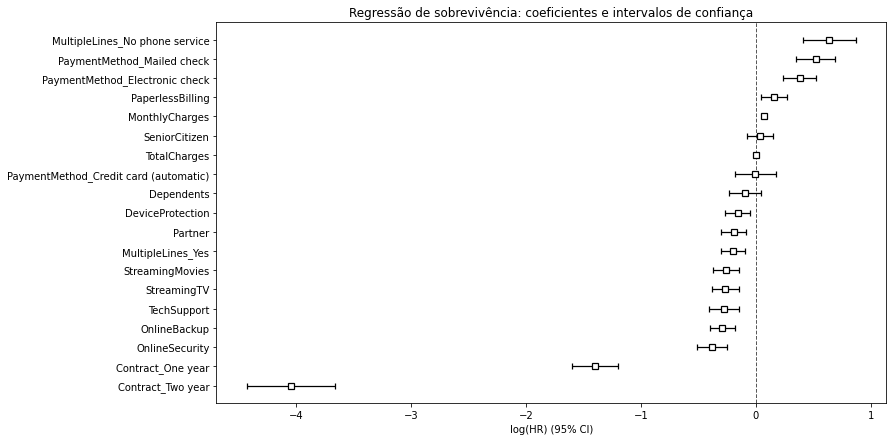

In [6]:
# plotting coefficients
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Regressão de sobrevivência: coeficientes e intervalos de confiança')
cph.plot(ax=ax_coef);

In [7]:
# função para criar curvas de Kaplan-Meier segmentadas
# por variáveis categóricas
def plot_categorical_survival(feature, t='tenure', event='Churn', df=churn_data, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

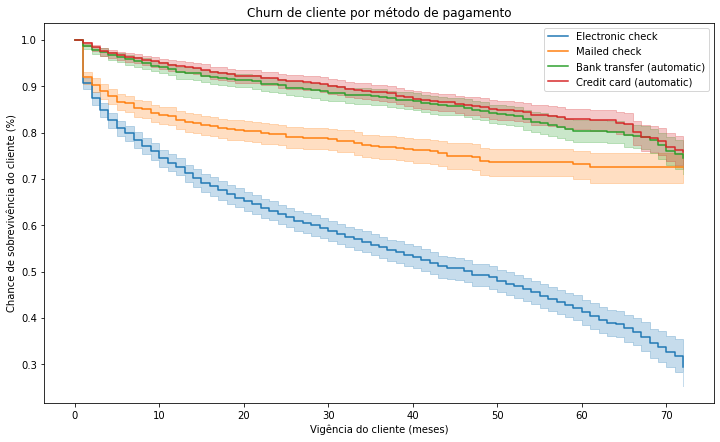

In [8]:
fig_pmt, ax_pmt = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='PaymentMethod', ax=ax_pmt)
ax_pmt.set_title('Churn de cliente por método de pagamento')
ax_pmt.set_xlabel('Vigência do cliente (meses)')
ax_pmt.set_ylabel('Chance de sobrevivência do cliente (%)')
plt.show()

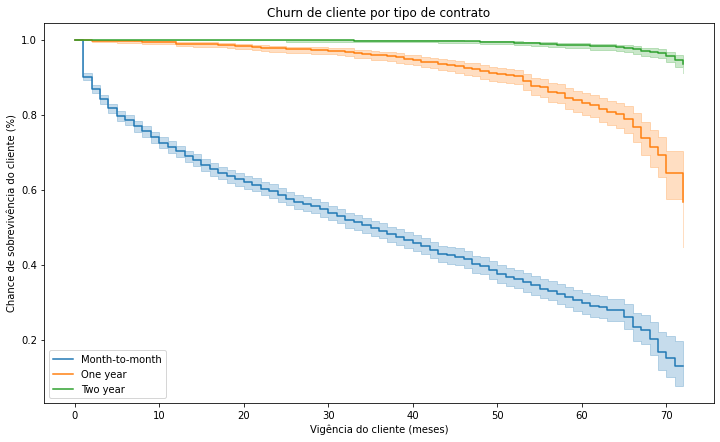

In [9]:
fig_contract, ax_contract = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='Contract', ax=ax_contract)
ax_contract.set_title('Churn de cliente por tipo de contrato')
ax_contract.set_xlabel('Vigência do cliente (meses)')
ax_contract.set_ylabel('Chance de sobrevivência do cliente (%)')
plt.show()

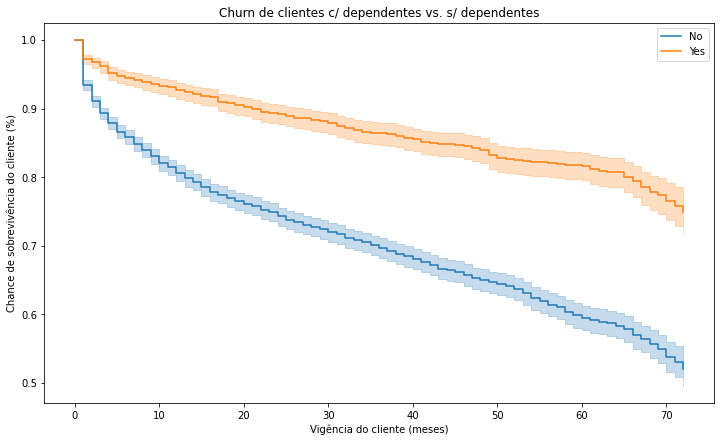

In [10]:
fig_dep, ax_dep = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='Dependents', ax=ax_dep)
ax_dep.set_title('Churn de clientes c/ dependentes vs. s/ dependentes')
ax_dep.set_xlabel('Vigência do cliente (meses)')
ax_dep.set_ylabel('Chance de sobrevivência do cliente (%)')
plt.show()

## A conclusão:

Como a empresa de telecomunicações analisada pode reduzir a rotatividade de clientes?

Após, termos analizados os dados, podemos fazer recomendações em 3 direções, respectivamente:

    1) Tipo de Contrato,
    2) Tipo do cliente e
    3) Forma de pagamento.

Para visualizar algumas dessas descobertas, ajustamos curvas de Kaplan-Meier baseadas nas categorias analisadas e as representamos nos gráficos próprios.

### Especificação do contrato:

A característica mais importante, de longe, é a presença de um contrato de Fidelizados ou não fidelizados. Os clientes têm 0,25 e 0,02, respectivamente, mais probabilidade de cancelar o serviço se estiverem sob contrato fidelizados.

As taxas de cancelamento são uma possível causa subjacente de ofertas temporárias. Desde que essas taxas não proíbam novas vendas, recomendamos continuar a incluí-las no maior número possível de contratos.

### Tipo do cliente:

Os clientes com planos familiares ou com dependentes têm 0,82 e 0,91 vezes mais probabilidade de cancelar do que clientes sem dependentes. Porém, as famílias grandes parecem ter menos probabilidade de mudar de provedor.

Isso pode ser devido a rendimentos mais altos, menos tempo para considerar opções ou outra combinação de fatores.

### Método de pagamento:

O método mais eficiente e mais recomendados como padrão para o cliente é o pagamento automático em conta corrente. Isso requer pouco esforço do cliente, não havendo falhas faciltia para permanecer inscrito.

Por outro lado, enviar uma conta pelo correio ou eletronicamente, é uma "dor". Requer mais esforço do cliente, quanto mais incovenientes mais difífil para ele permanecer inscrito.